#### Notebook config

In [34]:
# %load ../../software/fullwavepy/fullwavepy/config/jupyter.py 
from arrau import *
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot', 'kmc_test'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(ERROR) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


Set the path for projects accessible by the computational cluster:

In [3]:
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano'

Init the existing synthetic project. 

In [4]:
s01 = ProjSyn('method_s01', path = './', cat=0)

All the metadata have been read from the runfile(s). For example:

In [6]:
s01.ttime

7.5

There are some exceptions, e.g. executables:

In [13]:
s01.exe

{}

Which need to be set anew:

In [14]:
exe = { 
    'fullwave':  '~/PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'segyprep':  '/home/kmc3817/light_PhD/fullwave3D/segyprep_v3.16/bin/segyprep_v3.16' } 

Moreover, box and dt are not correct:

In [50]:
s01.box, s01.dt

([0, 17000.0, 0, 18000.0, 0, 4000.0], 2.5)

That's why we need:

In [88]:
xp = PROTEUS()
box = xp.box['kol1'].box
dt = s01.dt / 1000.
box

[8000.0, 25000.0, -3000.0, 15000.0, 0, 4000.0]

# Project

In [54]:
# init project 
# path = path_eph
path = './'
# env = {'SLAVES_WAVEFIELDSVTR': -100} # take a wavefield snapshot every 100 time steps
kwargs = dict(path=path, exe=exe, box=box, dt=dt, ns=s01.ns, dx=s01.dx, cat=0)
i01 = ProjInv('method_i01', **kwargs)

## Inp

Prepare input:

In [74]:
i01.i.obs.raw.fname

'.//method_i01//inp/method_i01-Observed_raw.sgy'

In [75]:
%%time 
i01.i.svp.dupl(s01.i.tvp.fname)
i01.i.rsg.dupl(s01.i.rsg.fname)
# i01.i.obs.dupl(s01.i.ose.fname) NOTE this is instead prepared by the pre-processor
i01.i.obs.raw.dupl(s01.i.ose.fname)
i01.i.rse.prep(fnames=[i01.i.obs.raw.name])
i01.i.sp.prep(reciprocity=True, ztype='d')

Content of  .//method_i01//inp/method_i01-RawSeis.txt : 
method_i01-Observed_raw.sgy
 
Content of  .//method_i01//inp/method_i01-SegyPrep.key : 
FFID : yes
addtodepth : 0
debug : yes
dtms : 2.5
dx : 50.0
fixedarray : yes
geometry : segy
io : sgy
maxoffset : 1000000.0
minoffset : 0
nx1 : 341
nx2 : 361
nx3 : 81
outseis : yes
outsource : yes
problem : tomography
reciprocity : True
retain : yes
text : yes
ttime : 7.5
unique : yes
xorigin : 8000.0
xshift : 0
yorigin : -3000.0
yshift : 0
ztype : d
 
CPU times: user 16 ms, sys: 28 ms, total: 44 ms
Wall time: 1.84 s


Pre-process the input. In particular `obs.raw` file is pre-processed and output as `obs` file. This matters only if the discretisation differs from the one in the synthetic project.

In [76]:
%%time 
i01.i.sp.run()
i01.i.rnf.prep(b_abs=40, e_abs=50)


 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to method_i01
 Preparing files for inversion...

 Grid points in-line:                    341
 Grid points cross-line:                 361
 Grid points vertically:                  81
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            17000.0000    
 Model width (metres):             18000.0000    
 Model depth (metres):             4000.00000    

 Modelling time step (ms):         2.50000000    
 Output data delta-T (ms):         2.50000000    
 Output data length (ms):          7500.00000    
 Output data length (samples):          3000
 Time steps to model:                   3000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:       no
 Use FFID instead of SOURCE numbers:     yes
 FFID numbers are unique

Process the observed data (`obs` file). This is quite slow (2.5 min), thus it may be a better idea to keep the processed data ready to be re-used.

In [78]:
%%time 
kw_filt = {'pad': 100, 'f1': 2, 'f2': 3, 'f3': 4.5, 'f4': 6.5, 'zerophase': False}
kw_mute = {'twin': 1, 'syn_file': s01.o.syn}
i01.i.obs.process(kw_filt, kw_mute)

CPU times: user 1min 50s, sys: 1.14 s, total: 1min 51s
Wall time: 2min 35s


The fully processed file has overwritten the initial version so that it is ready for FWI at the path:

In [86]:
i01.i.obs.fname

'.//method_i01//inp/method_i01-Observed.sgy'

The processing function als outputs an intermediate-result file:

In [84]:
i01.i.obs.fil.fname

'.//method_i01//inp/method_i01-Observed_filtered.sgy'

The raw data has been prepared by us manually and was used by the pre-processor without actually being modified:

In [87]:
i01.i.obs.raw.fname

'.//method_i01//inp/method_i01-Observed_raw.sgy'

To QC the processing, we can plot all of these above files with a single command:

CPU times: user 1.31 s, sys: 460 ms, total: 1.77 s
Wall time: 10.2 s


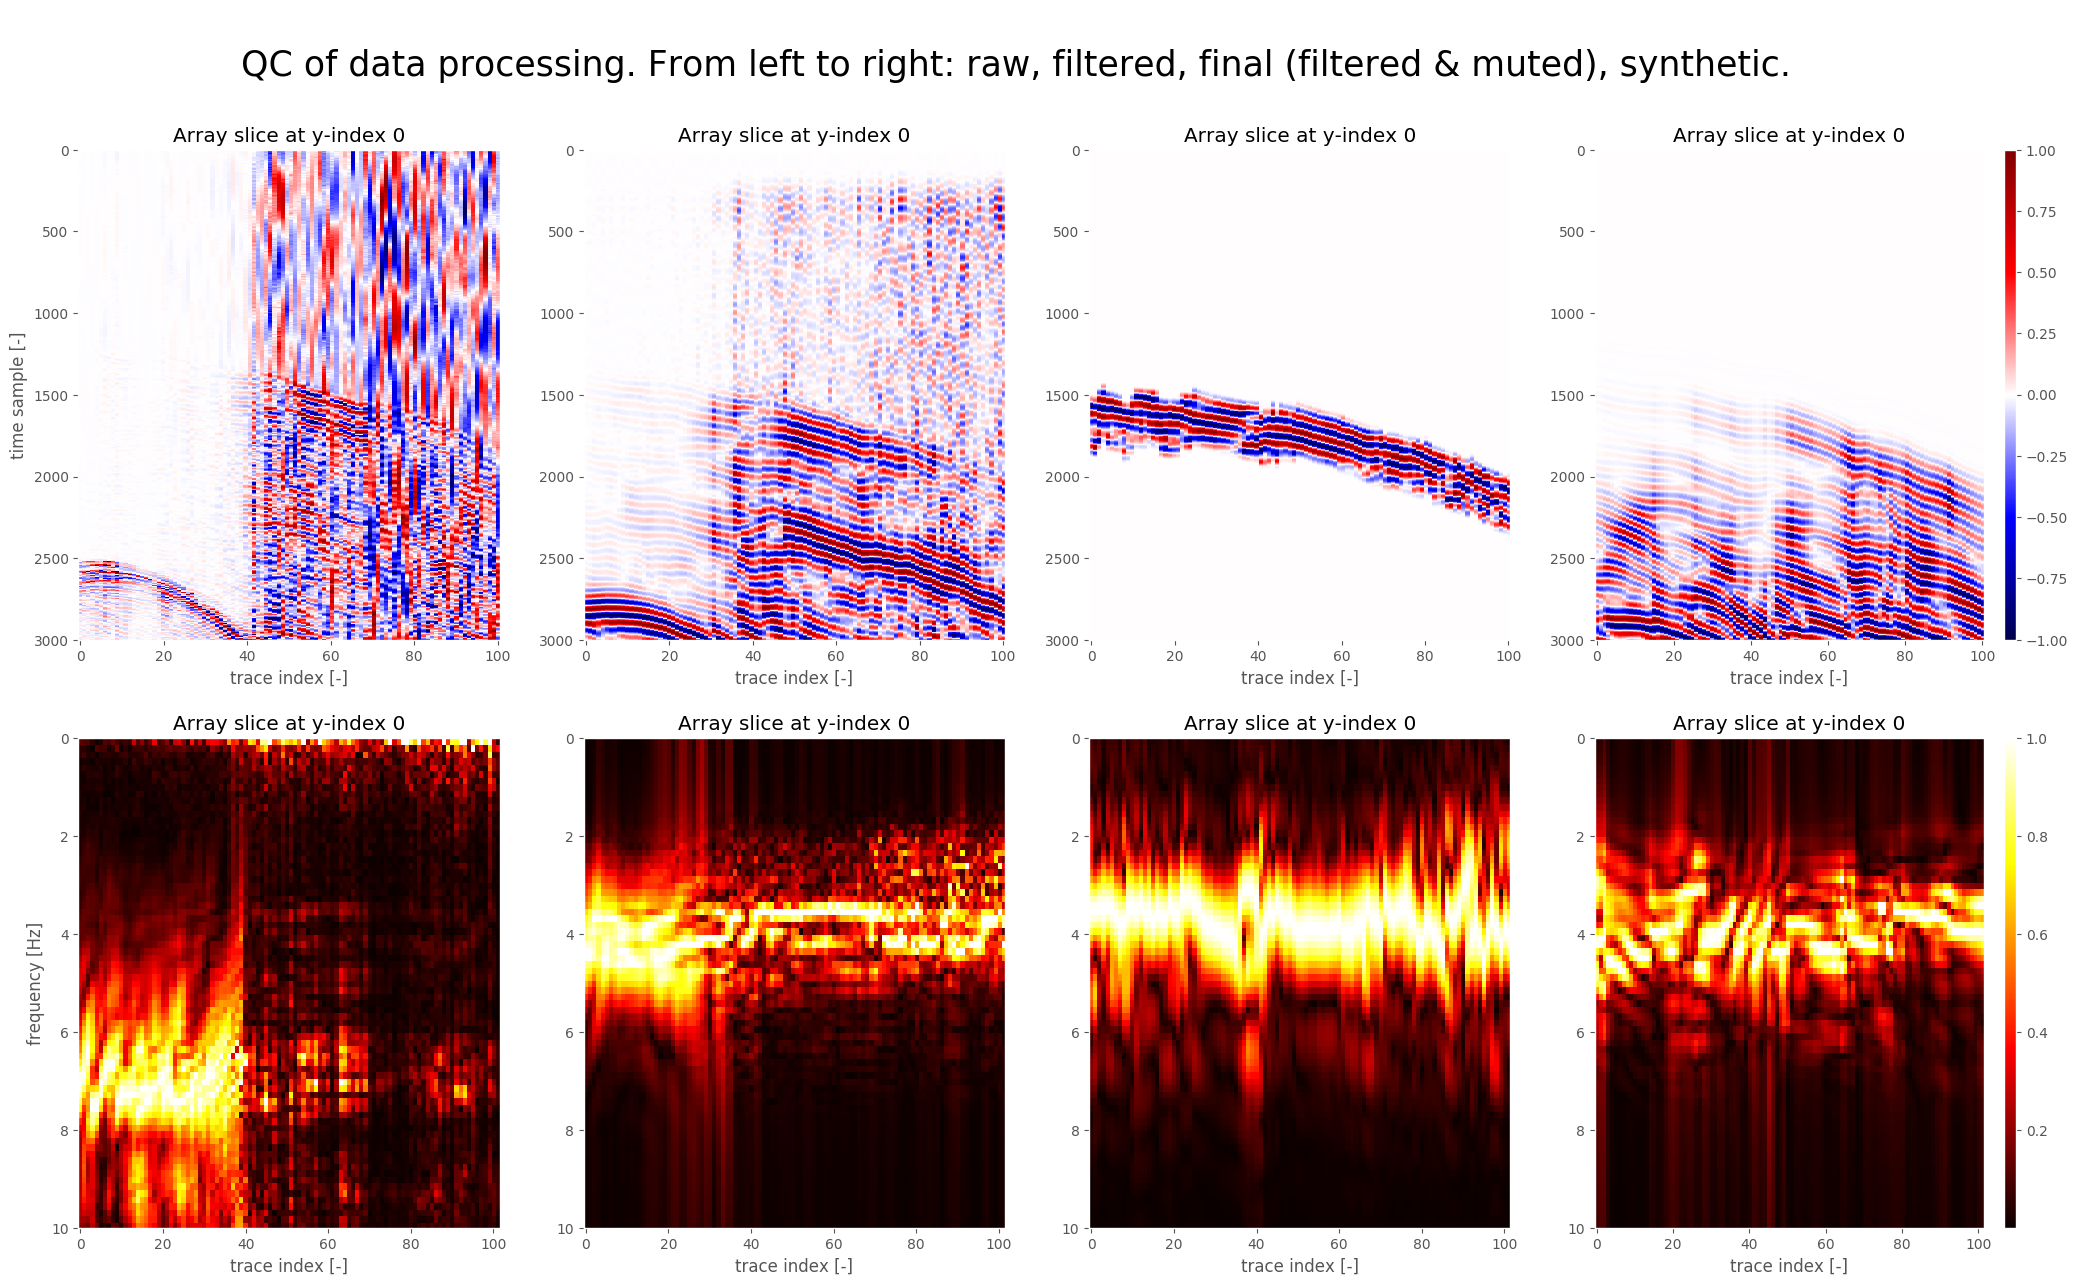

In [82]:
%%time 
qc_filt(i01, s01, sid=4139, ep=5, overwrite=1, overwrite_mmp=1)

## Run

Two nodes calculate 3000 time samples in exactly 1 hour.

In [81]:
# syn.i.rsync('my_eph') 
# syn.i.pbs.no[0].prep(q='debug')
# syn.i.pbs.no[1].prep(select=2, q='pqmrwarn') # it took exactly an hour!!!
# syn.i.rsync('my_eph') 

On the `cx1` PBS cluster, first **set environment** vars:

In [71]:
# dir=my_ephemeral/PROJECTS/ch08_Kolumbo_volcano; code=rev690; proj=method_syn01; q=pqmrwarn

and then **submit** the job(s):

In [72]:
# dir=$dir; code=$code; q=$q; projs=$(ls $dir | grep $proj);
# for proj in $projs; do echo $proj; fwi_qsub.sh $dir/$proj/ $proj $code $q; donea

## Out

### Logs

In [80]:
no = 1
# syn.o.o.no[no].cat()
# syn.o.je.no[no].cat()
# syn.o.jo.no[no].cat()

# ...